In [4]:
from dataset_utils.preprocessing import letterbox_image_padded
from dataset_utils.eval import evaluate_dataset, evaluate_image
from misc_utils.visualization import visualize_detections
from models.frcnn import FRCNN
from PIL import Image
from tog.attacks import *
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline

weights = 'model_files/FRCNN.pth'  # TODO: Change this path to the victim model's weights

detector = FRCNN().cuda(device=0).load(weights)

eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations
path = "dataset/VOCdevkit/VOC2007/JPEGImages/"

# scores = evaluate_dataset(detector, path, attack=None)
# print("(benign) mAP is:", scores["map"])

# scores = evaluate_dataset(detector, path, attack=tog_attention, attack_params={"n_iter": n_iter, "eps": eps, "eps_iter":eps_iter})
# print("(attention) mAP is:", scores["map"])

# scores = evaluate_dataset(detector, path, attack=tog_untargeted, attack_params={"n_iter": n_iter, "eps": eps, "eps_iter":eps_iter})
# print("(untargeted) mAP is:", scores["map"])

<Figure size 640x480 with 0 Axes>

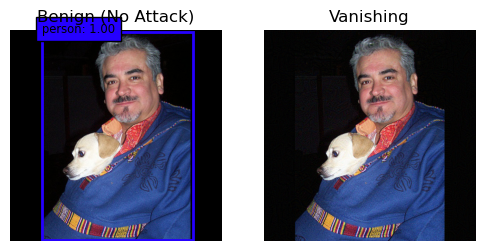

In [16]:
fpath = 'dataset/VOCdevkit/VOC2007/JPEGImages/000001.jpg'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
x_adv = tog_vanishing(detector, x_query)
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                     'Vanishing': (x_adv, detections_adv, detector.model_img_size, detector.classes)})



<Figure size 640x480 with 0 Axes>

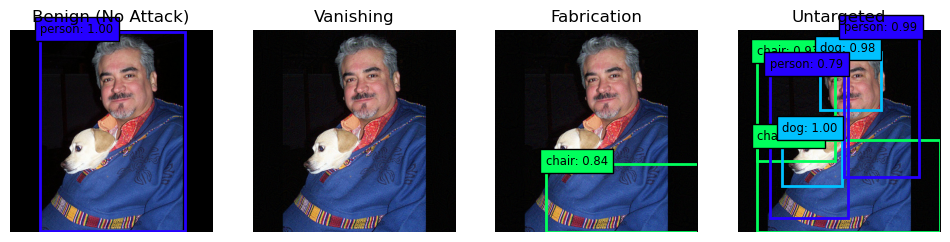

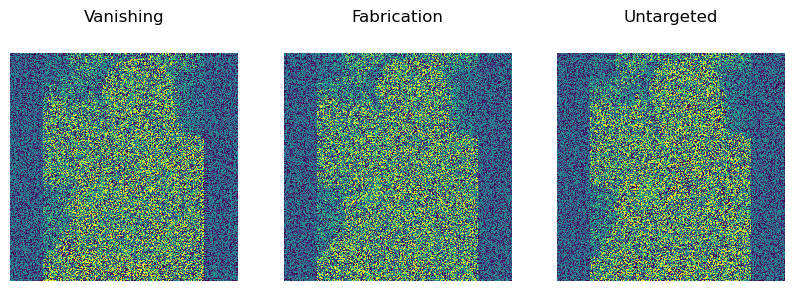

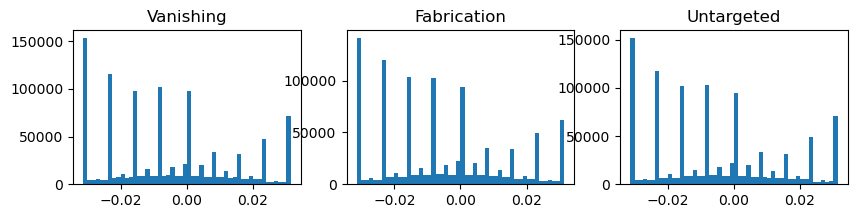

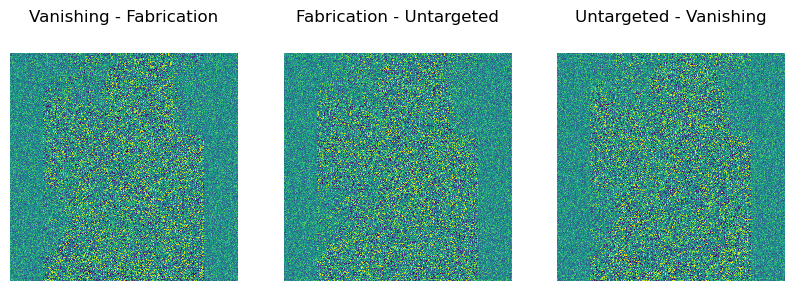

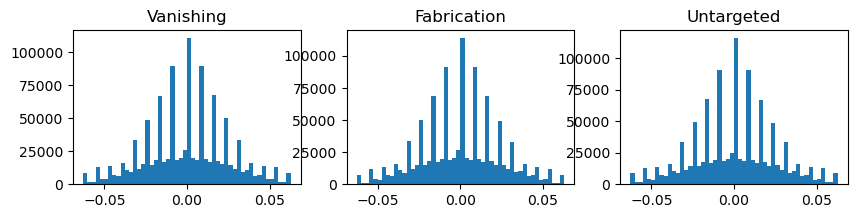

In [31]:
def visualize_perts(path):
    n_iter=10
    eps=8/255.
    eps_iter=2/255.
    
    input_image = Image.open(fpath)
    x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
    detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
    
    x_adv_vanish = tog_vanishing(detector, x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
    detections_adv_vanish = detector.detect(x_adv_vanish, conf_threshold=detector.confidence_thresh_default)
    pert_vanish = x_query - x_adv_vanish
    
    x_adv_fab = tog_fabrication(detector, x_query, eps=eps, eps_iter=eps_iter)
    detections_adv_fab = detector.detect(x_adv_fab, conf_threshold=detector.confidence_thresh_default)
    pert_fab = x_query - x_adv_fab
    
    x_adv_untarget = tog_untargeted(detector, x_query, eps=eps, eps_iter=eps_iter)
    detections_adv_untarget = detector.detect(x_adv_untarget, conf_threshold=detector.confidence_thresh_default)
    pert_untarget = x_query - x_adv_untarget
    
    visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                         'Vanishing': (x_adv_vanish, detections_adv_vanish, detector.model_img_size, detector.classes),
                         'Fabrication': (x_adv_fab, detections_adv_fab, detector.model_img_size, detector.classes),
                         'Untargeted': (x_adv_untarget, detections_adv_untarget, detector.model_img_size, detector.classes)})
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    for a in ax.flat:
        a.set_axis_off()
    ax[0].matshow(pert_vanish.squeeze()[:, :, 0])
    ax[0].set_title("Vanishing")
    ax[1].matshow(pert_fab.squeeze()[:, :, 0])
    ax[1].set_title("Fabrication")
    ax[2].matshow(pert_untarget.squeeze()[:, :, 0])
    ax[2].set_title("Untargeted")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
#     for a in ax.flat:
#         a.set_axis_off()
    ax[0].hist(pert_vanish.flatten(), bins=50)
    ax[0].set_title("Vanishing")
    ax[1].hist(pert_fab.flatten(), bins=50)
    ax[1].set_title("Fabrication")
    ax[2].hist(pert_untarget.flatten(), bins=50)
    ax[2].set_title("Untargeted")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    for a in ax.flat:
        a.set_axis_off()
    ax[0].matshow(pert_vanish.squeeze()[:, :, 0] - pert_fab.squeeze()[:, :, 0])
    ax[0].set_title("Vanishing - Fabrication")
    ax[1].matshow(pert_fab.squeeze()[:, :, 0] - pert_untarget.squeeze()[:, :, 0])
    ax[1].set_title("Fabrication - Untargeted")
    ax[2].matshow(pert_untarget.squeeze()[:, :, 0] - pert_vanish.squeeze()[:, :, 0])
    ax[2].set_title("Untargeted - Vanishing")
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
#     for a in ax.flat:
#         a.set_axis_off()
    ax[0].hist((pert_vanish - pert_fab).flatten(), bins=50)
    ax[0].set_title("Vanishing")
    ax[1].hist((pert_fab - pert_untarget).flatten(), bins=50)
    ax[1].set_title("Fabrication")
    ax[2].hist((pert_untarget - pert_vanish).flatten(), bins=50)
    ax[2].set_title("Untargeted")
    plt.show()
    

visualize_perts('dataset/VOCdevkit/VOC2007/JPEGImages/000001.jpg')
# pert = x_adv - x_query
# plt.matshow(pert.squeeze()[:, :, 2])
# plt.show()
# plt.hist(pert.flatten())
# plt.show()